In [4]:
import os

In [5]:
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir="./data"
os.makedirs(data_dir,exist_ok=True)




In [6]:
print(torch. __version__)


1.13.0+cpu


In [7]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import Planetoid
import networkx as nx
from networkx.algorithms import community

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir="./data"
os.makedirs(data_dir,exist_ok=True)

In [9]:
dataset=Planetoid(root=data_dir,name='Cora')

In [10]:
data=dataset[0]

In [11]:
print(f'Number of nodes: {data.num_nodes}')

Number of nodes: 2708


In [12]:
print(f'Number of edges: {data.num_edges}')

Number of edges: 10556


In [13]:
# there are no nodes not connected by edges
print(f'Has isolated nodes: {data.has_isolated_nodes()}')

Has isolated nodes: False


In [14]:
# there are no self-loops
print(f'Has self-loops: {data.has_self_loops()}')

Has self-loops: False


In [15]:
# the third line of code shows that edges are not directional that means the edge count is double the actual count because of the bi-directional edge information included
print(f'Is undirected: {data.is_undirected()}')

Is undirected: True


In [16]:
# how edge information is stored
# the edge held by the 30th node as an example

edge_index=data.edge_index.numpy()
print(edge_index)

[[   0    0    0 ... 2707 2707 2707]
 [ 633 1862 2582 ...  598 1473 2706]]


In [17]:
edge_example=edge_index[:,np.where(edge_index[0]==30)[0]]

In [18]:
edge_example

array([[  30,   30,   30,   30,   30,   30],
       [ 697,  738, 1358, 1416, 2162, 2343]], dtype=int64)

In [19]:
# draw a network centered on this node
node_example=np.unique(edge_example.flatten())
plt.figure(figsize=(10,6))
G=nx.Graph()

<Figure size 720x432 with 0 Axes>

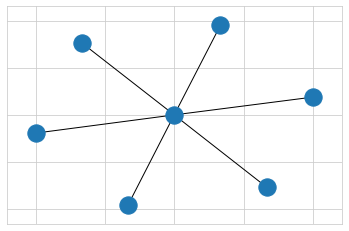

In [20]:
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example[0],edge_example[1])))
nx.draw_networkx(G,with_labels=False)

In [21]:
# Degree in graph theory means the number of edges joining a vertex(node) in a graph
# How many edges does each node have on average
print(f'Average node degree: {data.num_edges/data.num_nodes: .2f}')


Average node degree:  3.90


In [22]:
# we found that the average node degree is 3.9, pretty low. we can check the overall distribution by drawing a histogram of the degree

G=to_networkx(data,to_undirected=True)
degrees=[val for (node,val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))

,count,mean,std,min,25%,50%,75%,max
0,2708.0,3.9,5.23,1.0,2.0,3.0,5.0,168.0


2708
10556


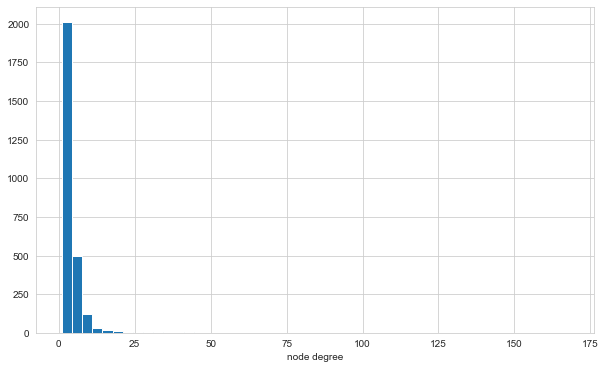

In [23]:
plt.figure(figsize=(10,6))
plt.hist(degrees,bins=50)
plt.xlabel("node degree")
plt.show()

In [24]:
# summarize A high degree means that they are connected to many nodes(papers)
# nodes with high degrees are likely to be important

threshold 0.011821204285186553


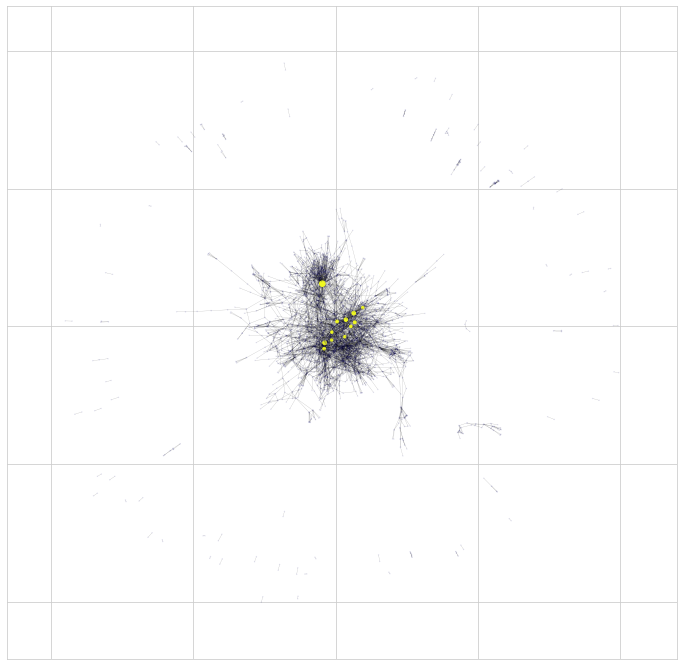

In [26]:
# find the 10 nodes with the highest degree are located
G=to_networkx(data,to_undirected=True)
pos=nx.spring_layout(G,seed=42)

cent=nx.degree_centrality(G)
node_size=list(map(lambda x: x*500,cent.values()))

cent_array=np.array(list(cent.values()))
threshold=sorted(cent_array,reverse=True)[10]
print("threshold",threshold)
cent_bin=np.where(cent_array>=threshold,1,0.1)

plt.figure(figsize=(12,12))
nodes=nx.draw_networkx_nodes(G,pos,node_size=node_size,cmap=plt.cm.plasma,node_color=cent_bin,nodelist=list(cent.keys()),alpha=cent_bin)
edges=nx.draw_networkx_edges(G,pos,width=0.25,alpha=0.3)
plt.show()

In [27]:
# the top 10 nodes with the highest degree are represented by yellow dots, and the other nodes are represented by gray dots.
# the yellow dots are proportional to the size of the degree.

In [28]:
# For each of the 1433 words, the number of features is expressed as 0 and 1 if the word is included or not included in the paper

In [29]:
print(f'Number of features: {data.num_node_features}')

Number of features: 1433


In [30]:
#The papers in the Cora dataset are labeled with 7 different labels

In [31]:
print(f"Number of classes: {dataset.num_classes}")

Number of classes: 7


In [32]:
label_dict={
    0:"Theory",
    1:"Reinforcement_Learning",
    2:"Genetic_Algorithms",
    3:"Neural_Networks",
    4:"Probabilistic_Methods",
    5:"Case_Based",
    6:"Rule_Learning"
}
data.y[:10]

tensor([3, 4, 4, 0, 3, 2, 0, 3, 3, 2])

In [33]:
# often the number of classes is not equal. Let's find out the number of each class.
counter=collections.Counter(data.y.numpy())
counter=dict(counter)
print(counter)

{3: 818, 4: 426, 0: 351, 2: 418, 1: 217, 5: 298, 6: 180}


In [34]:
count=[x[1] for x in sorted(counter.items())]

In [35]:
print(count)

[351, 217, 418, 818, 426, 298, 180]


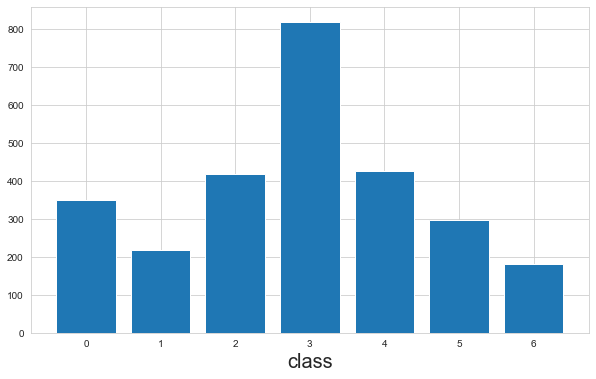

In [36]:
plt.figure(figsize=(10,6))
plt.bar(range(7),count)
plt.xlabel("class",size=20)
plt.show()

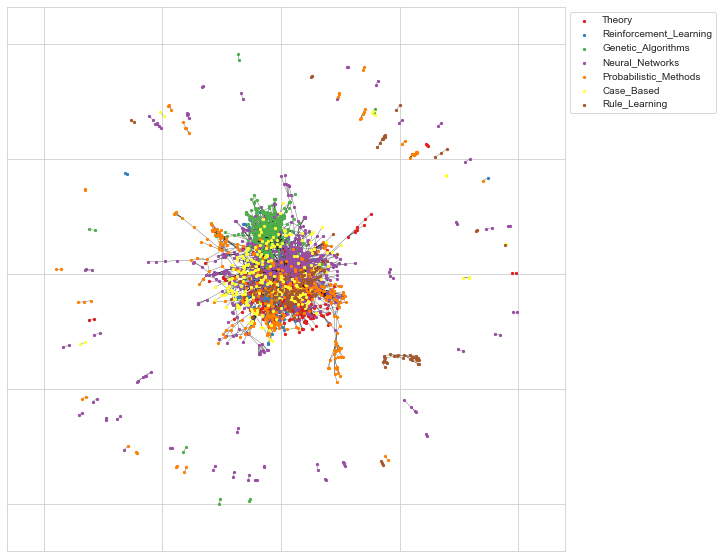

In [38]:
# draw a network diagram to see if the classes are distributed coherently
G=to_networkx(data,to_undirected=True)
node_color=[]
nodelist=[[],[],[],[],[],[],[]]

colorlist=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33','#a65628']
labels=data.y

for n,i in enumerate(labels):
    node_color.append(colorlist[i])
    nodelist[i].append(n)

pos=nx.spring_layout(G,seed=42)
plt.figure(figsize=(10,10))
labellist=list(label_dict.values())

for num,i in enumerate(zip(nodelist,labellist)):
    n,l=i[0],i[1]
    nx.draw_networkx_nodes(G,pos,nodelist=n,node_size=5,node_color=colorlist[num],label=l)
nx.draw_networkx_edges(G,pos,width=0.25)
plt.legend(bbox_to_anchor=(1,1),loc='upper left')


In [39]:
# homophily
# nodes with the same characteristics are often connected. This property is called homophily
#for the seven classes we looked at earlier, we will see how many nodes of the same class are connected by edges and vice versa

label: 0
1527 edges
{0: 1068, 1: 32, 3: 161, 6: 80, 5: 75, 4: 88, 2: 23}
label: 1
1029 edges
{1: 818, 3: 67, 0: 32, 5: 28, 2: 62, 4: 20, 6: 2}
label: 2
1826 edges
{2: 1654, 3: 53, 1: 62, 5: 30, 0: 23, 4: 2, 6: 2}
label: 3
2838 edges
{3: 2350, 2: 53, 4: 137, 5: 54, 0: 161, 6: 16, 1: 67}
label: 4
1592 edges
{4: 1320, 3: 137, 0: 88, 1: 20, 6: 6, 5: 19, 2: 2}
label: 5
1086 edges
{2: 30, 5: 834, 0: 75, 3: 54, 1: 28, 4: 19, 6: 46}
label: 6
658 edges
{6: 506, 5: 46, 0: 80, 4: 6, 3: 16, 1: 2, 2: 2}


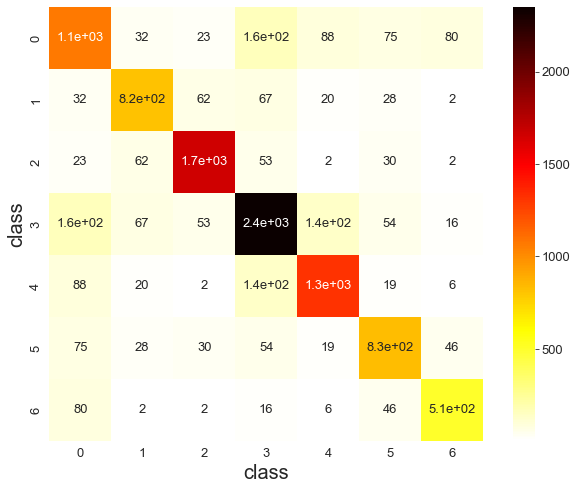

In [42]:
labels=data.y.numpy()
connected_labels_set=list(map(lambda x:labels[x],data.edge_index.numpy()))
connected_labels_set=np.array(connected_labels_set)

def add_missing_keys(counter,classes):
    for x in classes:
        if x not in counter.keys():
            counter[x]=0
    return counter

label_connection_counts=[]
for i in range(7):
    print(f"label: {i}")
    connected_labels=connected_labels_set[:,np.where(connected_labels_set[0]==i)[0]]
    print(connected_labels.shape[1],"edges")
    counter=collections.Counter(connected_labels[1])
    counter=dict(counter)
    print(counter)
    counter=add_missing_keys(counter,range(7))
    items=sorted(counter.items())
    items=[x[1]for x in items]
    label_connection_counts.append(items)

label_connection_counts=np.array(label_connection_counts)
plt.figure(figsize=(9,7))
plt.rcParams["font.size"]=13
hm=sns.heatmap(label_connection_counts,annot=True,cmap='hot_r',cbar=True,square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [43]:
# we can see that there are a great many nodes that are connected to each other belonging to the same class.
label_connection_counts.diagonal().sum()/label_connection_counts.sum()

0.8099658961727927

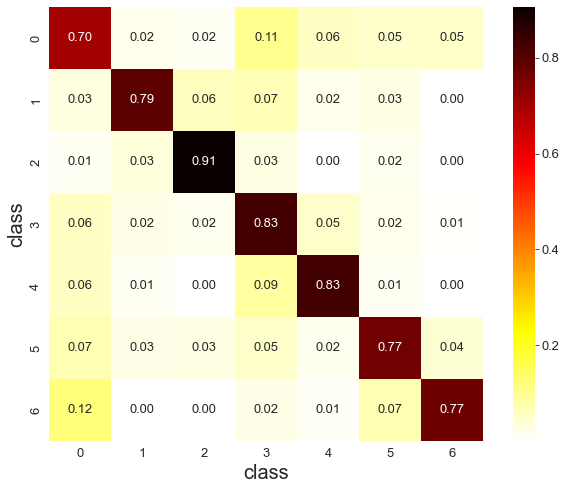

In [44]:
# from above, it seems that about 81% of the edges are connected within the same class
def scaling(array):
    return array/sum(array)
label_connection_counts_scaled=np.apply_along_axis(scaling,1,label_connection_counts)

plt.figure(figsize=(9,7))
plt.rcParams["font.size"]=13
hm=sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True
)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [45]:
# from above, we can see that for all classes, the highest number of edges are tied to the same class. This is also most true for Class2,where about 91% of the edges are joined within the same class.On the other hand,the trend is relatively weak in Class0,with about 70% of the edges being within the same class.

In [46]:
#Train Test Split
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Number of validation nodes: {data.val_mask.sum()}')
print(f'Number of test nodes: {data.test_mask.sum()}')

Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


In [47]:
# however, the total of these nodes not add up to 2708 cases

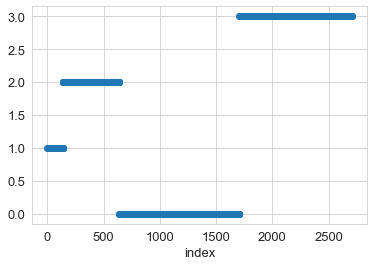

In [52]:
# Let's check which data is used and which data is not
split_type_array=np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask==True)[0]]=1
split_type_array[np.where(data.val_mask==True)[0]]=2
split_type_array[np.where(data.test_mask==True)[0]]=3

plt.scatter(range(2708),split_type_array)
plt.xlabel("index")
plt.show()

Training {3: 20, 4: 20, 0: 20, 2: 20, 1: 20, 5: 20, 6: 20}
Validation {4: 81, 3: 158, 0: 61, 6: 29, 1: 36, 2: 78, 5: 57}
Test {3: 319, 2: 144, 0: 130, 1: 91, 5: 103, 4: 149, 6: 64}


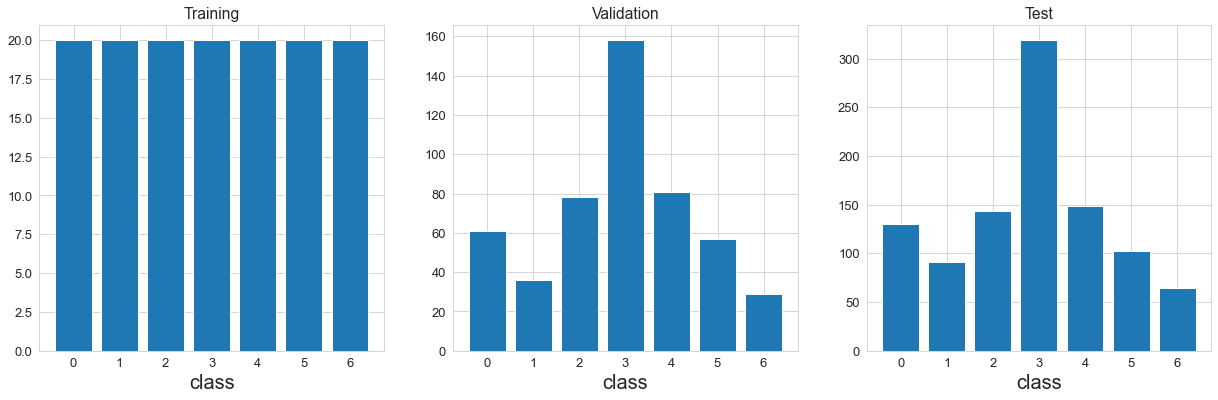

In [56]:
titles=["Training","Validation","Test"]
fig,axes=plt.subplots(ncols=3,figsize=(21,6))

for i in range(3):
    counter=collections.Counter(data.y.numpy()[np.where(split_type_array==i+1)[0]])
    counter=dict(counter)
    print(titles[i],counter)
    count=[x[1] for x in sorted(counter.items())]
    #plt.figure(figsize=(10,6))
    axes[i].bar(range(7),count)
    axes[i].set_xlabel("class",size=20)
    axes[i].set_title(titles[i])
plt.show()